# Data analysis

Combine the posterior samples of all CHIME bursts from `magnetron2_FRB`. Let's make one histogram per parameter for the combined output. 

We apply the following procedure:
1) Take one random sample from each posterior sample file
2) Extract all the spike model parameters from this random sample, such as the number of spikes, peak position, amplitude, skewness, and rise time scale. 
3) Add them to a list
4) Do this for all bursts 
5) Repeat process 100 times
6) Make for all 100 runs a histogram: taking min and max values of all runs, and making sure the number of bins and bin edges are the same for every histogram 
7) For the 100 histograms calculate the mean and standard deviation per bin
8) Finally: use that mean and standard deviation to make a new histogram of all the combinend results

In [79]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats, integrate
import random
from itertools import compress
import seaborn as sns
import pandas as pd
from cfod import catalog 
import os

In [57]:
res_dir = "/home/mariska/UvA/magnetron2/output_no_scat/"
posterior_files = glob.glob(f"{res_dir}*/*_posterior_sample.txt")

nbins = 250

# Set thresholds to filter spike parameters on 
# thr_min_amp = 0.1
# thr_max_amp = 100
# thr_min_scale = 0.3 
# thr_max_scale = 10

sns.set_theme(style="darkgrid")

## Extract and order parameters from posterior files

In [4]:
def get_data(datadir:str, frb_name: str):
    data = np.loadtxt(f"{datadir}{frb_name}.dat")

    time = data[:,0]
    flux = data[:,1]
    flux_err = data[:,2]

    return time, flux, flux_err

In [6]:
def get_params(file, sample: np.ndarray, idx: int):
        """ Get the number of spikes, all the spike peak positions, amplitudes, scales, 
        and skewnessess for one posterior sample. Turn the skewness in log values. 

        Parameters:
        sample  : numpy.ndarray -- all posterior samples of one file 
        idx     : int           -- index corresponding to one posterior sample  
        
        Returns:
        npos    : list   -- contains spike peak positions for one random posterior sample 
        amp     : list   -- similar but with amplitude 
        scale   : list   -- similar but with scale
        skew    : list   -- similar but with skewness
        """
        # get nbursts per random sample 
        nbursts = sample[idx, 9]

        # individual burst parameters for 100 components of a random sample
        npos = sample[idx,10:110] # peak position for all burst components
        amp = sample[idx,110:210] # amplitude for all burst components
        scale = sample[idx,210:310] # rise time for all burst components
        skew = sample[idx, 310:410] # skewness parameter all burst components
        

        # take only the non-zero components 
        npos = npos[:int(nbursts)]
        amp = amp[:int(nbursts)]
        scale = scale[:int(nbursts)]
        skew = skew[:int(nbursts)]

        skew = [np.log(i) for i in skew]  # turn into log values

        return nbursts, npos, amp, scale, skew   

In [45]:
def filter_params(npos, amp, scale, skew, thr_min_amp, thr_max_amp, thr_min_scale, thr_max_scale):
    """Filter the spikes based on an amplitude and rise time scale threshold.
    """
    
    if thr_min_scale and thr_max_scale and thr_min_amp and thr_max_amp is not None: 
        filter_amp = [True if i > thr_min_amp and i < thr_max_amp else False for i in amp]
        filter_scale = [True if i > thr_min_scale and i < thr_max_scale else False for i in scale]
        filt = [a and b for a, b in zip(filter_amp, filter_scale)]

    elif thr_min_amp and thr_max_amp is not None: 
        filt = [True if i > thr_min_amp and i < thr_max_amp else False for i in amp]

    elif thr_min_scale and thr_max_scale is not None: 
        filt = [True if i > thr_min_scale and i < thr_max_scale else False for i in scale]

    else: 
        # don't filter 
        filt = [True for i in amp]

    # filter the parameters 
    filtered_npos = list(compress(npos, filt))
    filtered_amp = list(compress(amp, filt))
    filtered_scale = list(compress(scale, filt))
    filtered_skew = list(compress(skew, filt))
    # get nbursts that are left after filtering 
    filtered_nbursts = len(filtered_npos)

    return filtered_nbursts, filtered_npos, filtered_amp, filtered_scale, filtered_skew

In [50]:
def get_all_params(posterior_files: list, thr_min_amp=None, thr_max_amp=None, thr_min_scale=None, thr_max_scale=None):      
        """Draw 100 random posterior files per burst. 
        Extract all the spike parameters for each posterior file, 
        save them into a list. Save all these lists into another list.

        Parameters:
        posterior_files : list  -- All posterior files 
        thr_min_amp     : float -- Lower amplitude threshold for filtering the spike parameters (default: None)
        thr_max_amp     : float -- Upper amplitude threshold for filtering the spike parameters (default: None)
        thr_min_scale   : float -- Lower rise time scale threshold for filtering the spike parameters (default: None)
        thr_max_scale   : float -- Upper rise time scale threshold for filtering the spike parameters (default: None)
        
        Returns:
        nbursts_all_files: list -- 2D list (number of files, 100 posterior files with number of spikes) 
        npos_all_files   : list -- 2D list (number of files, 100 posterior files with spike peak position) 
        amp_all_files    : list -- 2D list (number of files, 100 posterior files with spike amplitudes) 
        scale_all_files  : list -- 2D list (number of files, 100 posterior files with spike rise time scales) 
        skew_all_files   : list -- 2D list (number of files, 100 posterior files with spike skewness) 
        wait_times_all_files: list -- 2D list (number of files, 100 posterior files with spike wait times) 
        fluence_all_files: list -- 2D list (number of files, 100 posterior files with spike fluence) 
        """
        nbursts_all_files = []
        npos_all_files = []
        amp_all_files = []
        scale_all_files = []
        skew_all_files = []
        wait_times_all_files = []
        fluence_all_files = []

        for file in posterior_files:
                # load all samples per file 
                sample = np.loadtxt(file, skiprows=2)
                nsamples = len(sample)

                # get FRB name 
                tns_name = file.split("/")[-1]
                tns_name = tns_name.split("_")[0]

                nbursts_one_file = []
                npos_one_file = []
                amp_one_file = []
                scale_one_file = []
                skew_one_file = []
                wait_times_one_file = []
                fluence_one_file = []

                try: 
                        # get 100 random posterior samples without replacement 
                        random.seed(10)
                        for idx in random.sample(range(0, nsamples), 100): 
                                # get the parameters per random sample 
                                nbursts, npos, amp, scale, skew = get_params(file, sample, idx)
                                                
                                filtered_nbursts, filtered_npos, filtered_amp, filtered_scale, filtered_skew = filter_params(npos, amp, scale, skew, thr_min_amp, thr_max_amp, thr_min_scale, thr_max_scale)
                                
                                fluences = []
                                for i in range(int(filtered_nbursts)):
                                        fluence = filtered_amp[i]*filtered_scale[i]*(1-np.exp(filtered_skew[i])) #NOT IN LOG SKEW 
                                        fluences.append(fluence)
                                
                                # calculate difference between adjacent peaks 
                                sorted_npos = np.sort(filtered_npos)
                                diff_npos = np.diff(sorted_npos)

                                # caculate wait time w CHIME's time resolution of 0.983 ms
                                dt_CHIME = 0.983
                                wait_time = diff_npos * dt_CHIME

                                # save all the parameters from one file in a list 
                                nbursts_one_file.append(filtered_nbursts)
                                npos_one_file.append(filtered_npos)
                                amp_one_file.append(filtered_amp)
                                scale_one_file.append(filtered_scale)
                                skew_one_file.append(filtered_skew)
                                wait_times_one_file.append(wait_time)
                                fluence_one_file.append(fluences)

                        # save all files into one list 
                        nbursts_all_files.append(nbursts_one_file) # shape (250,100)
                        npos_all_files.append(npos_one_file) 
                        amp_all_files.append(amp_one_file)
                        scale_all_files.append(scale_one_file)
                        skew_all_files.append(skew_one_file)
                        wait_times_all_files.append(wait_times_one_file)
                        fluence_all_files.append(fluence_one_file)

                except Exception as e:
                        print(f"{e} for {file}")

        return nbursts_all_files, npos_all_files, amp_all_files, scale_all_files, skew_all_files, wait_times_all_files, fluence_all_files

In [32]:
def order(all_files):
    """Order all files (from shape 250, 100) of one parameter
    into a list of shape (100,) with every row containing one sample 
    from each posterior file. 
    """
    # transpose to get shape (100,250): every row contains one sample from each posterior file
    p = np.matrix(all_files).T.tolist()
    # merge the samples per row into one list 
    final = []
    for sample in p:
        param = []
        for file in sample:
            if isinstance(file, float) or isinstance(file, int): 
                param.append(file)
            else: 
                param.extend(file)
        final.append(param) # shape (100,)

    return final

In [58]:
nbursts_all_files, npos_all_files, amp_all_files, scale_all_files, skew_all_files, wait_times_all_files, fluence_all_files = get_all_params(posterior_files, thr_min_amp, thr_max_amp, thr_min_scale, thr_max_scale)

Sample larger than population or is negative for /home/mariska/UvA/magnetron2/output_no_scat/FRB20181222A_waterfall/FRB20181222A_waterfall_posterior_sample.txt


In [59]:
final_nbursts = order(nbursts_all_files)
final_npos = order(npos_all_files)
final_amp = order(amp_all_files)
final_scale = order(scale_all_files)
final_skew = order(skew_all_files)
final_wait_time = order(wait_times_all_files)
final_fluence = order(fluence_all_files)

/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


### Prepare data for histogram 

In [41]:
def get_min_max(final):
    """Get the minimum and maximum value.
    """
    # get all parameters into one list 
    all_param = []
    for i in final:
        all_param.extend(i)

    return min(all_param), max(all_param)

def confidence_interval(final, confidence: float = 0.95):
    """Get the confidence interval.
    """
    # get all parameters into one list 
    all_param = []
    for i in final:
        all_param.extend(i)

    m = np.mean(all_param)
    s = np.std(all_param) 
    dof = len(all_param)-1 

    t_crit = np.abs(stats.t.ppf((1-confidence)/2,dof))
    ci = (m-s*t_crit/np.sqrt(len(all_param)), m+s*t_crit/np.sqrt(len(all_param)))

    return ci 

In [60]:
min_nbursts, max_nbursts = get_min_max(final_nbursts)
min_npos, max_npos = get_min_max(final_npos)
min_amp, max_amp = get_min_max(final_amp)
min_scale, max_scale = get_min_max(final_scale)
min_skew, max_skew = get_min_max(final_skew)
min_wait_time, max_wait_time = get_min_max(final_wait_time)
min_fluence, max_fluence = get_min_max(final_fluence)

print(f"The minimum and maximum nbursts is: {min_nbursts, max_nbursts}")
print(f"The minimum and maximum npos is: {min_npos, max_npos}")
print(f"The minimum and maximum amplitude is: {min_amp, max_amp}")
print(f"The minimum and maximum scale is {min_scale, max_scale}")
print(f"The minimum and maximum log(skewness) is {min_skew, max_skew}")
print(f"The minimum and maximum wait time is {min_wait_time, max_wait_time}")
print(f"The minimum and maximum fluence is {min_fluence, max_fluence}")

The minimum and maximum nbursts is: (0, 100)
The minimum and maximum npos is: (-4.21942e+01, 40.7961)
The minimum and maximum amplitude is: (0.00062508, 291.029)
The minimum and maximum scale is (0.00404788, 1385.7)
The minimum and maximum log(skewness) is (-7.312722011300148, 5.947818255512834)
The minimum and maximum wait time is (0.0, 68.2247218)
The minimum and maximum fluence is (-2159.6368187854796, 437.04099209014083)


In [61]:
print(f"The 95% confidence interval of nbursts is: {confidence_interval(final_nbursts)}")
print(f"The 95% confidence interval of npos is: {confidence_interval(final_npos)}")
print(f"The 95% confidence interval of amplitude is: {confidence_interval(final_amp)}")
print(f"The 95% confidence interval of scale is {confidence_interval(final_scale)}")
print(f"The 95% confidence interval of log(skewness) is {confidence_interval(final_skew)}")
print(f"The 95% confidence interval of wait time is {confidence_interval(final_wait_time)}")
print(f"The 95% confidence interval of fluence is {confidence_interval(final_fluence)}")

The 95% confidence interval of nbursts is: (4.473596951406378, 4.7763204039655225)
The 95% confidence interval of npos is: (-1.2115598147286002, -0.9738534488457878)
The 95% confidence interval of amplitude is: (1.0199977019803599, 1.0690165962995983)
The 95% confidence interval of scale is (1.3305387408701688, 1.414905427790351)
The 95% confidence interval of log(skewness) is (-1.4452051774713657, -1.422082972025049)
The 95% confidence interval of wait time is (3.9312797727742534, 4.020963503767693)
The 95% confidence interval of fluence is (-0.09072359514763909, 0.05042440397885759)


Text(0.5, 0, 'log(skewness)')

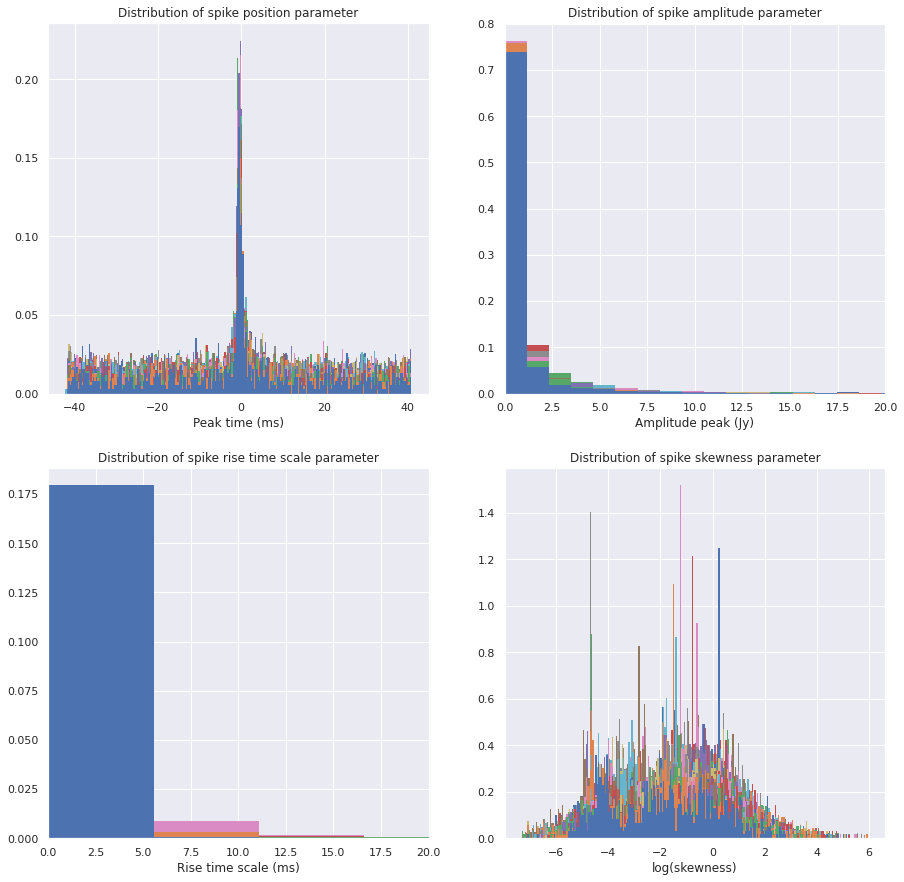

In [63]:
__, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
n_npos, bins_npos, __ = axes[0].hist(final_npos, bins=nbins,  range=[min_npos, max_npos],  histtype="stepfilled", density=True, edgecolor='none')
axes[0].set_title("Distribution of spike position parameter")
axes[0].set_xlabel("Peak time (ms)")

n_amp, bins_amp, __ = axes[1].hist(final_amp, bins=nbins, range=[min_amp, max_amp], histtype="stepfilled", density=True, edgecolor='none')
axes[1].set_title("Distribution of spike amplitude parameter")
axes[1].set_xlabel("Amplitude peak (Jy)")
axes[1].set_xlim(0, 20)

n_scale, bins_scale, __ = axes[2].hist(final_scale, bins=nbins, range=[min_scale, max_scale], histtype="stepfilled", density=True, edgecolor='none')
axes[2].set_title("Distribution of spike rise time scale parameter")
axes[2].set_xlabel("Rise time scale (ms)")
axes[2].set_xlim(0, 20)

n_skew, bins_skew, __ = axes[3].hist(final_skew, bins=nbins, range=[min_skew, max_skew], histtype="stepfilled", density=True, edgecolor='none')
axes[3].set_title("Distribution of spike skewness parameter")
axes[3].set_xlabel("log(skewness)")

(0.0, 40.0)

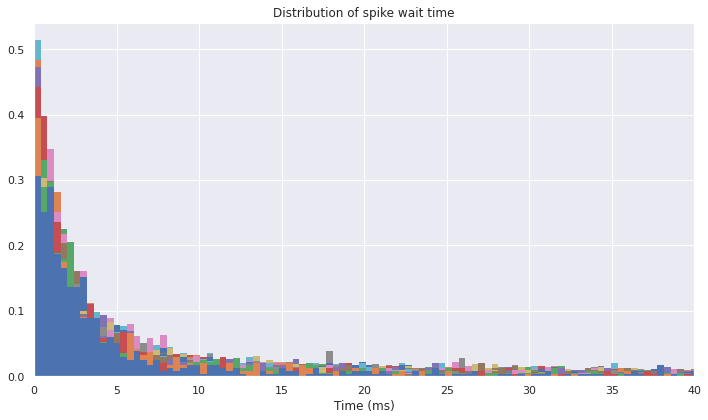

In [77]:
nbins_wait_time = 200
plt.figure(figsize=(10,6))
n_wait_time, bins_wait_time, __ = plt.hist(final_wait_time, bins=nbins_wait_time, range=[min_wait_time, max_wait_time], 
                                           histtype="stepfilled", density=True, edgecolor='none')
plt.title("Distribution of spike wait time")
plt.xlabel("Time (ms)")
plt.xlim(0,40)

(0.0, 25.0)

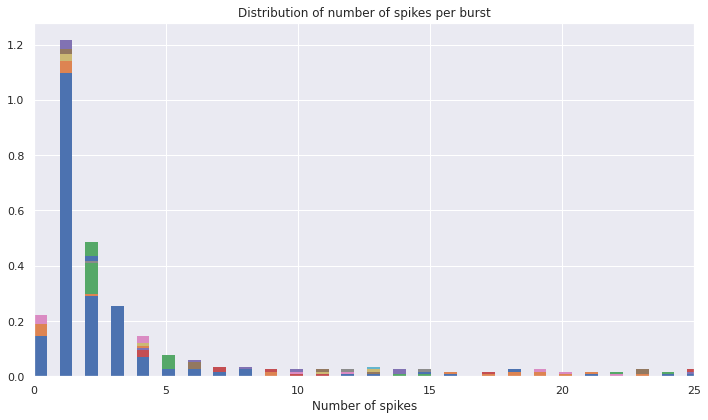

In [78]:
nbins_nbursts = 200

plt.figure(figsize=(10,6))
n_nbursts, bins_nbursts, __ = plt.hist(final_nbursts, bins=nbins_nbursts, histtype="stepfilled", density=True, edgecolor='none')
plt.title("Distribution of number of spikes per burst")
plt.xlabel("Number of spikes")
plt.xlim(0,25)

# standard deviation per bin is zero because all values per bin are the same, 
# so putting in error bars doesn't make sense

### Create the final histogram 

The plots above show all draws on top of each other. Now create plots which show the average and standard deviation per bin. 

In [93]:
def bin_values(n, bins):
    """Get the position of the middle of each bin, the mean value (height), 
    and its standard deviation.
    """
    # transpose to get shape (40, 100): every row is one bin and contains 100 histograms 
    bin_heights = np.matrix(n).T.tolist() 

    mean_bin_heights = [np.mean(i) for i in bin_heights]
    std_bin_heights = [np.std(i) for i in bin_heights]

    mids = 0.5*(bins[1:] + bins[:-1])

    return mids, mean_bin_heights, std_bin_heights

(0.0, 0.35125076846294745)

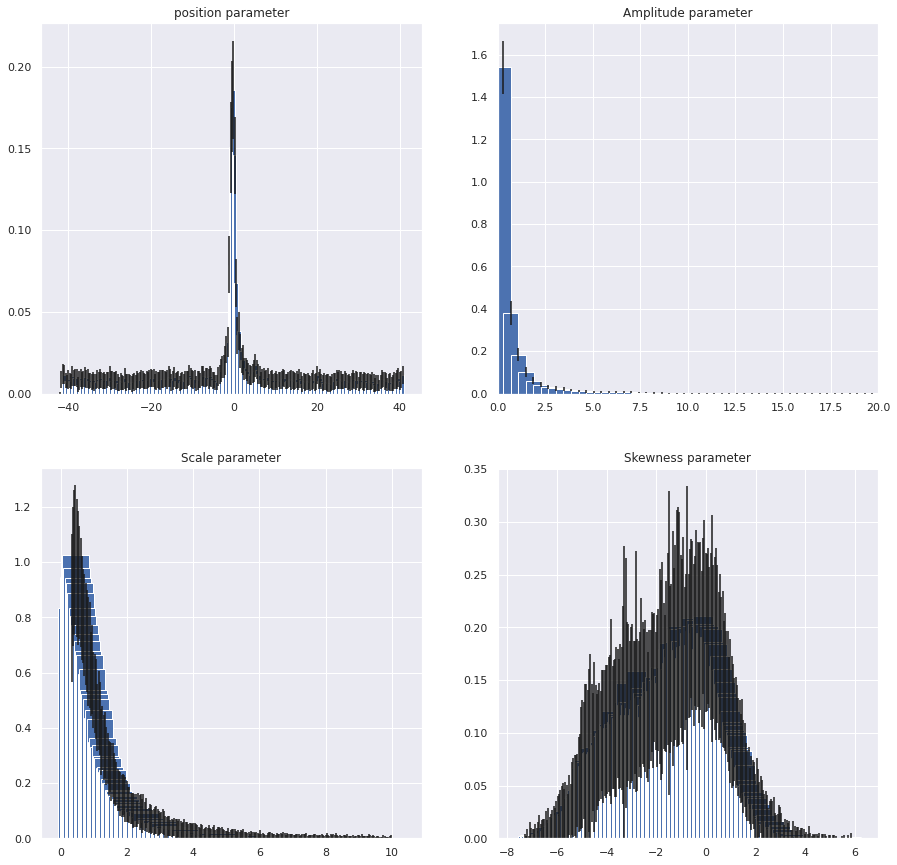

In [42]:
mids_npos, mean_bins_npos, std_bins_npos = bin_values(n_npos, bins_npos)
mids_amp, mean_bins_amp, std_bins_amp = bin_values(n_amp, bins_amp)
mids_scale, mean_bins_scale, std_bins_scale = bin_values(n_scale, bins_scale)
mids_skew, mean_bins_skew, std_bins_skew = bin_values(n_skew, bins_skew)

__, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
axes[0].bar(x=mids_npos, height=mean_bins_npos, yerr=std_bins_npos)
axes[0].set_title("position parameter")
axes[0].set_ylim(0)

axes[1].bar(x=mids_amp, height=mean_bins_amp, yerr=std_bins_amp)
axes[1].set_title("Amplitude parameter")
axes[1].set_xlim(0,20)
axes[1].set_ylim(0)

axes[2].bar(x=mids_scale, height=mean_bins_scale, yerr=std_bins_scale)
axes[2].set_title("Scale parameter")
# axes[2].set_xlim(0,200)
axes[2].set_ylim(0)


axes[3].bar(x=mids_skew, height=mean_bins_skew, yerr=std_bins_skew)
axes[3].set_title("Skewness parameter")
axes[3].set_ylim(0)

(0.0, 0.4489443037144528)

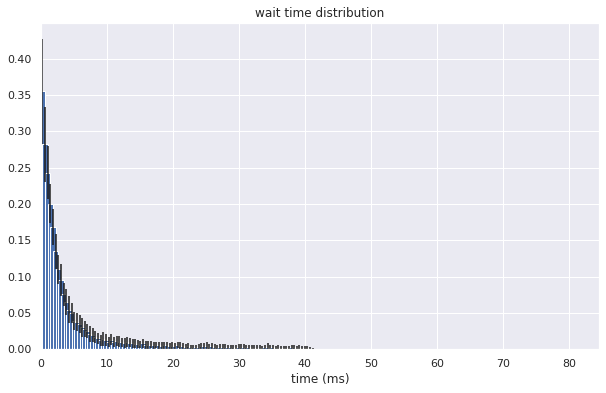

In [43]:
mids_wait_time, mean_bins_wait_time, std_bins_wait_time = bin_values(n_wait_time, bins_wait_time)

plt.figure(figsize=(10,6))
plt.bar(x=mids_wait_time, height=mean_bins_wait_time, yerr=std_bins_wait_time)
plt.title("wait time distribution")
plt.xlabel("time (ms)")
plt.xlim(0)
plt.ylim(0)

(0.0, 1.2174935981943795)

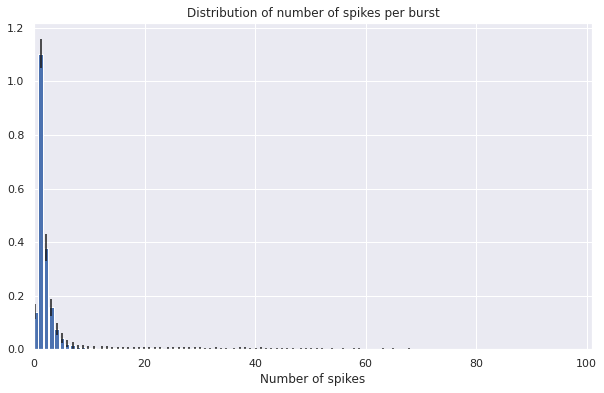

In [44]:
nbins_nbursts = 100
mids_nbursts, mean_nbursts, std_nbursts = bin_values(n_nbursts, bins_nbursts)

plt.figure(figsize=(10,6))
plt.bar(x=mids_nbursts, height=mean_nbursts, yerr=std_nbursts)
plt.title("Distribution of number of spikes per burst")
plt.xlabel("Number of spikes")
plt.xlim(0)
plt.ylim(0)

### Now seperate out repeaters from non-repeaters 

In [64]:
# These are all the repeaters (tns_name) in the CHIME/FRB catalog
# Not all repeaters are used during analysis
# repeaters = ["FRB20180814A", "FRB20180908B","FRB20180911C","FRB20180916B", "FRB20180917A", "FRB20180917A", "FRB20180917A", 
# "FRB20180919A", "FRB20181017A","FRB20181019A", "FRB20181019A","FRB20181028A", "FRB20181028A", "FRB20181028A", "FRB20181028A",
# "FRB20181028A", "FRB20181030A","FRB20181030B", "FRB20181104A","FRB20181104B", "FRB20181118C", "FRB20181119D", "FRB20181119D",
# "FRB20181119D", "FRB20181119A","FRB20181120B","FRB20181120C", "FRB20181128A","FRB20181128A","FRB20181219A","FRB20181222A",
# "FRB20181222A","FRB20181222A","FRB20181222A","FRB20181223A","FRB20181223A","FRB20181225A","FRB20181226A","FRB20181226A",
# "FRB20190103A","FRB20190116A","FRB20190116B","FRB20190117A","FRB20190126A","FRB20190208A","FRB20190208A","FRB20190208A",
# "FRB20190208A","FRB20190209A","FRB20190210A","FRB20190212A","FRB20190213A","FRB20190213B","FRB20190213B","FRB20190216A",
# "FRB20190222A","FRB20190301A","FRB20190301A","FRB20190303A","FRB20190313A","FRB20190406A","FRB20190417A","FRB20190421A",
# "FRB20190421A","FRB20190515C","FRB20190517B","FRB20190518A","FRB20190518E","FRB20190519A","FRB20190519A","FRB20190519B",
# "FRB20190519B","FRB20190519B","FRB20190519B","FRB20190519C","FRB20190527B","FRB20190603A","FRB20190604A","FRB20190604F",
# "FRB20190604F","FRB20190604F","FRB20190605A","FRB20190605B","FRB20190605B","FRB20190605B","FRB20190606A","FRB20190611A",
# "FRB20190611A","FRB20190621A","FRB20190625E","FRB20190625E","FRB20190625E","FRB20190626A","FRB20190630A"]

# These are all the first bursts of the repeaters 
repeaters = ['FRB20180814A', 'FRB20180908B', 'FRB20180916B', 'FRB20181017A', 'FRB20181030A', 'FRB20181119A', 'FRB20181128A', 
'FRB20181128A', 'FRB20190116B', 'FRB20190117A', 'FRB20190208A', 'FRB20190208A', 'FRB20190208A', 'FRB20190208A', 'FRB20190209A', 
'FRB20190212A', 'FRB20190213A', 'FRB20190222A', 'FRB20190303A', 'FRB20190417A', 'FRB20190604A']

In [82]:
non_repeaters = []
cnt = 0
for file in glob.glob(f"{res_dir}*/*_posterior_sample.txt"):
    cnt += 1
    file = file.split("/")
    file = file[-1]
    non_repeaters.append(file[0:12])

non_repeaters = [elem for elem in non_repeaters if elem not in repeaters]

np_posterior_files = []
for non_repeater in non_repeaters: 
    np_file = f"{res_dir}{non_repeater}_waterfall/{non_repeater}_waterfall_posterior_sample.txt"
    np_posterior_files.append(np_file)
     

rp_posterior_files = []
for repeater in repeaters: 
     rp_file = f"{res_dir}{repeater}_waterfall/{repeater}_waterfall_posterior_sample.txt"
     if os.path.exists(rp_file) == True:
          rp_posterior_files.append(rp_file)

print(f"From the total of {cnt} analysed FRBs, {len(np_posterior_files)} are non_repeaters and {len(rp_posterior_files)} are repeaters")

From the total of 243 analysed FRBs, 236 are non_repeaters and 7 are repeaters


#### First analyse the repeaters

In [85]:
rp_nbursts_all_files, rp_npos_all_files, rp_amp_all_files, rp_scale_all_files, rp_skew_all_files, rp_wait_times_all_files, rp_fluence_all_files = get_all_params(rp_posterior_files, thr_min_amp, thr_max_amp, thr_min_scale, thr_max_scale)

In [86]:
rp_final_nbursts = order(rp_nbursts_all_files)
rp_final_npos = order(rp_npos_all_files)
rp_final_amp = order(rp_amp_all_files)
rp_final_scale = order(rp_scale_all_files)
rp_final_skew = order(rp_skew_all_files)
rp_final_wait_time = order(rp_wait_times_all_files)
rp_final_fluence = order(rp_fluence_all_files)

/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


Text(0.5, 1.0, 'Repeater skewness parameter')

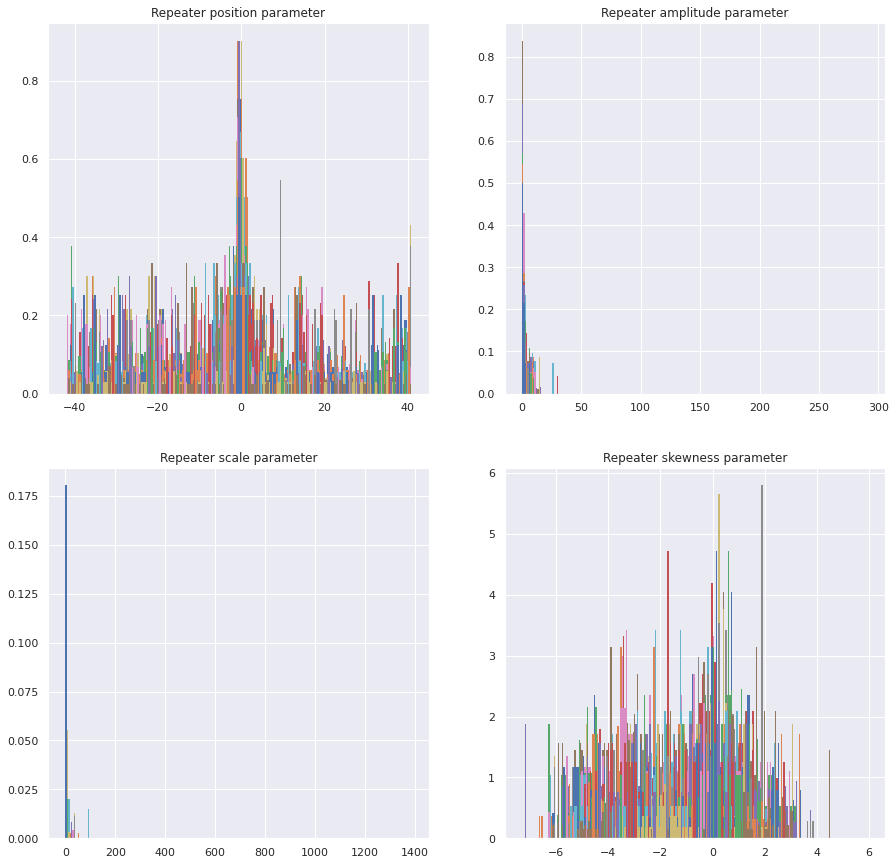

In [102]:
__, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
rp_n_npos, rp_bins_npos, __ = axes[0].hist(rp_final_npos, bins=nbins,  range=[min_npos, max_npos], histtype="stepfilled", density=True, edgecolor='none')
axes[0].set_title("Repeater position parameter")

rp_n_amp, rp_bins_amp, __ = axes[1].hist(rp_final_amp, bins=nbins, range=[min_amp, max_amp], histtype="stepfilled", density=True, edgecolor='none')
axes[1].set_title("Repeater amplitude parameter")

rp_n_scale, rp_bins_scale, __ = axes[2].hist(rp_final_scale, bins=nbins, range=[min_scale, max_scale], histtype="stepfilled", density=True, edgecolor='none')
axes[2].set_title("Repeater scale parameter")

rp_n_skew, rp_bins_skew, __ = axes[3].hist(rp_final_skew, bins=nbins, range=[min_skew, max_skew], histtype="stepfilled", density=True, edgecolor='none')
axes[3].set_title("Repeater skewness parameter")

#### Now analyse non-repeaters

In [88]:
np_nbursts_all_files, np_npos_all_files, np_amp_all_files, np_scale_all_files, np_skew_all_files, np_wait_times_all_files, np_fluence_all_files = get_all_params(np_posterior_files, thr_min_amp, thr_max_amp, thr_min_scale, thr_max_scale)

Sample larger than population or is negative for /home/mariska/UvA/magnetron2/output_no_scat/FRB20181222A_waterfall/FRB20181222A_waterfall_posterior_sample.txt


In [89]:
np_final_nbursts = order(np_nbursts_all_files)
np_final_npos = order(np_npos_all_files)
np_final_amp = order(np_amp_all_files)
np_final_scale = order(np_scale_all_files)
np_final_skew = order(np_skew_all_files)
np_final_wait_time = order(np_wait_times_all_files)
np_final_fluence = order(np_fluence_all_files)

/home/mariska/anaconda3/lib/python3.9/site-packages/numpy/matrixlib/defmatrix.py:145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = N.array(data, dtype=dtype, copy=copy)


Text(0.5, 1.0, 'Non-repeater skewness parameter')

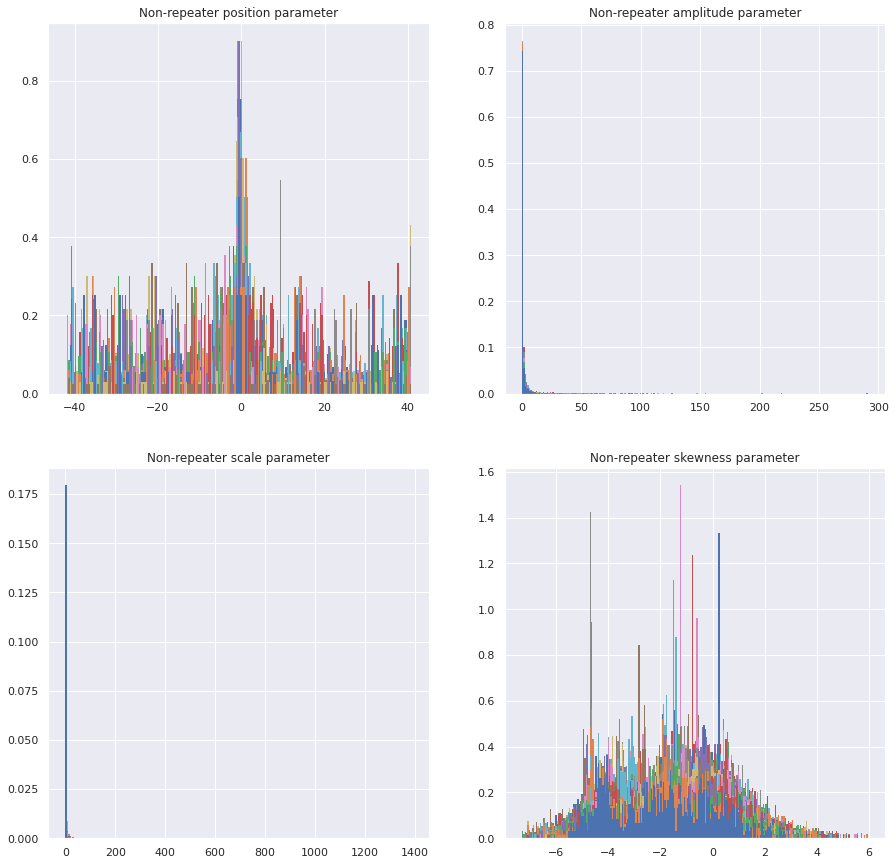

In [103]:
__, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
np_n_npos, np_bins_npos, __ = axes[0].hist(rp_final_npos, bins=nbins,  range=[min_npos, max_npos], histtype="stepfilled", density=True, edgecolor='none')
axes[0].set_title("Non-repeater position parameter")

np_n_amp, np_bins_amp, __ = axes[1].hist(np_final_amp, bins=nbins, range=[min_amp, max_amp], histtype="stepfilled", density=True, edgecolor='none')
axes[1].set_title("Non-repeater amplitude parameter")

np_n_scale, np_bins_scale, __ = axes[2].hist(np_final_scale, bins=nbins, range=[min_scale, max_scale], histtype="stepfilled", density=True, edgecolor='none')
axes[2].set_title("Non-repeater scale parameter")

np_n_skew, np_bins_skew, __ = axes[3].hist(np_final_skew, bins=nbins, range=[min_skew, max_skew], histtype="stepfilled", density=True, edgecolor='none')
axes[3].set_title("Non-repeater skewness parameter")

#### Time to plot the average of repeaters versus non-repeaters

In [98]:
def combine(list_one: list, list_two: list):
    """Combine two lists of the same length
    into new list per index
    """
    new_list = [(x + y)/2 for x, y in zip(list_one, list_two)]

    return new_list

def substract(list_one: list, list_two: list):
    """Substract two lists of the same length
    into new list per index
    """
    new_list = [x - y for x, y in zip(list_one, list_two)]

    return new_list

def add(list_one: list, list_two: list):
    """Add two lists of the same length
    into new list per index
    """
    new_list = [x + y for x, y in zip(list_one, list_two)]

    return new_list

In [94]:
rp_mids_npos, rp_mean_bins_npos, rp_std_bins_npos = bin_values(rp_n_npos, rp_bins_npos)
rp_mids_amp, rp_mean_bins_amp, rp_std_bins_amp = bin_values(rp_n_amp, rp_bins_amp)
rp_mids_scale, rp_mean_bins_scale, rp_std_bins_scale = bin_values(rp_n_scale, rp_bins_scale)
rp_mids_skew, rp_mean_bins_skew, rp_std_bins_skew = bin_values(rp_n_skew, rp_bins_skew)

np_mids_npos, np_mean_bins_npos, np_std_bins_npos = bin_values(np_n_npos, np_bins_npos)
np_mids_amp, np_mean_bins_amp, np_std_bins_amp = bin_values(np_n_amp, np_bins_amp)
np_mids_scale, np_mean_bins_scale, np_std_bins_scale = bin_values(np_n_scale, np_bins_scale)
np_mids_skew, np_mean_bins_skew, np_std_bins_skew = bin_values(np_n_skew, np_bins_skew)

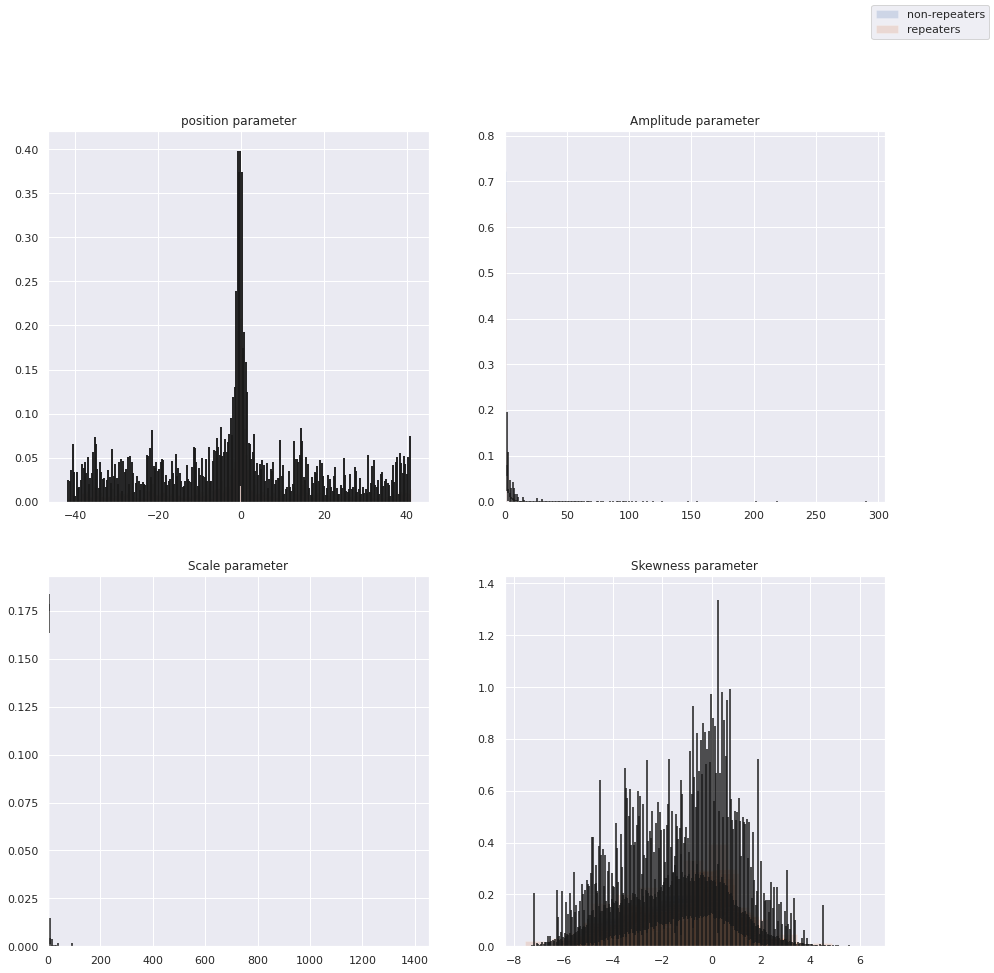

In [95]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
axes[0].bar(x=np_mids_npos, height=np_mean_bins_npos, yerr=np_std_bins_npos, alpha=0.2, label="non-repeaters")
axes[0].bar(x=rp_mids_npos, height=rp_mean_bins_npos, yerr=rp_std_bins_npos, alpha=0.2, label="repeaters")
axes[0].set_title("position parameter")
axes[0].set_ylim(0)

axes[1].bar(x=np_mids_amp, height=np_mean_bins_amp, yerr=np_std_bins_amp, alpha=0.2)
axes[1].bar(x=rp_mids_amp, height=rp_mean_bins_amp, yerr=rp_std_bins_amp, alpha=0.2)
axes[1].set_title("Amplitude parameter")
axes[1].set_ylim(0)
axes[1].set_xlim(0)

axes[2].bar(x=np_mids_scale, height=np_mean_bins_scale, yerr=np_std_bins_scale, alpha=0.2)
axes[2].bar(x=rp_mids_scale, height=rp_mean_bins_scale, yerr=rp_std_bins_scale, alpha=0.2)
axes[2].set_title("Scale parameter")
axes[2].set_ylim(0)
axes[2].set_xlim(0)

axes[3].bar(x=np_mids_skew, height=np_mean_bins_skew, yerr=np_std_bins_skew, alpha=0.2)
axes[3].bar(x=rp_mids_skew, height=rp_mean_bins_skew, yerr=rp_std_bins_skew, alpha=0.2)
axes[3].set_title("Skewness parameter")

axes[3].set_ylim(0)
axes[3].set_ylim(0)

fig.legend()

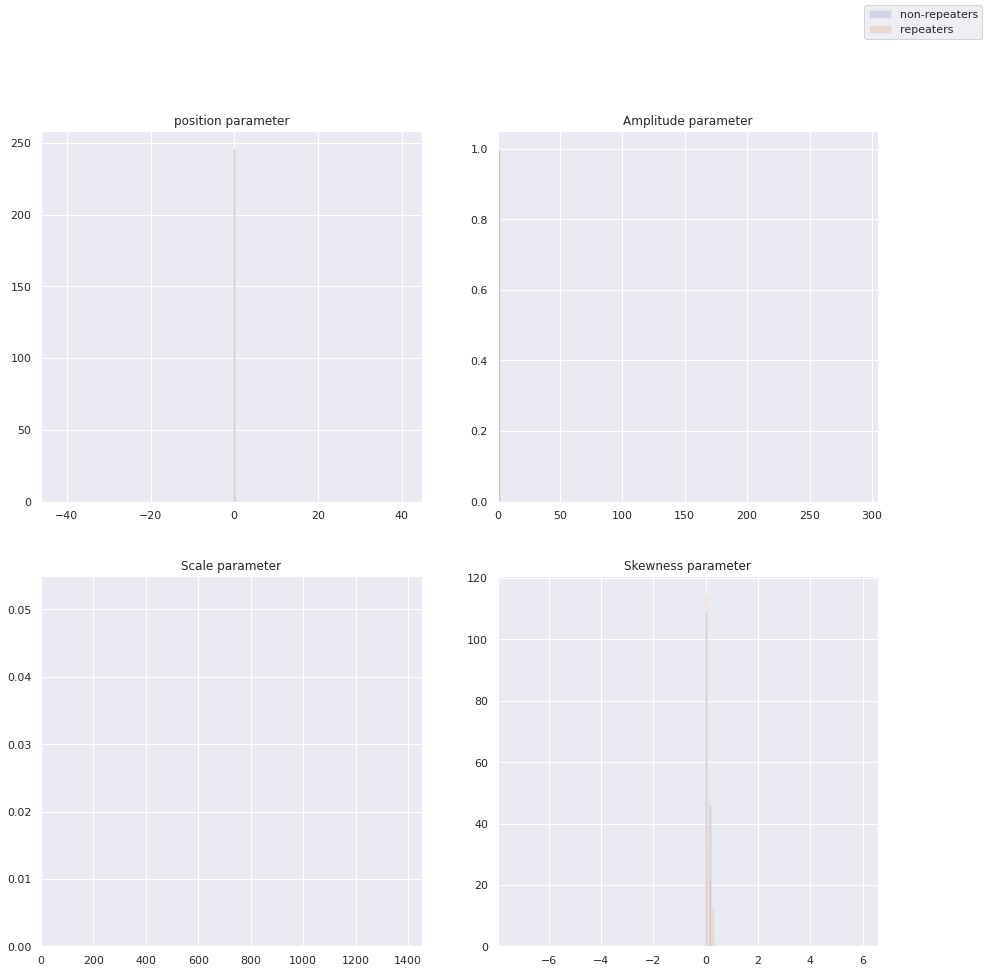

In [96]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
axes[0].hist(x=np_mean_bins_npos, bins=np_mids_npos, alpha=0.2, label="non-repeaters")
axes[0].hist(x=rp_mean_bins_npos, bins=rp_mids_npos,  alpha=0.2, label="repeaters")
axes[0].set_title("position parameter")
axes[0].set_ylim(0)

axes[1].hist(bins=np_mids_amp, x=np_mean_bins_amp, alpha=0.2)
axes[1].hist(bins=rp_mids_amp, x=rp_mean_bins_amp, alpha=0.2)
axes[1].set_title("Amplitude parameter")
axes[1].set_ylim(0)
axes[1].set_xlim(0)

axes[2].hist(bins=np_mids_scale, x=np_mean_bins_scale, alpha=0.2)
axes[2].hist(bins=rp_mids_scale, x=rp_mean_bins_scale, alpha=0.2)
axes[2].set_title("Scale parameter")
axes[2].set_ylim(0)
axes[2].set_xlim(0)

axes[3].hist(bins=np_mids_skew, x=np_mean_bins_skew,  alpha=0.2)
axes[3].hist(bins=rp_mids_skew, x=rp_mean_bins_skew,  alpha=0.2)
axes[3].set_title("Skewness parameter")

axes[3].set_ylim(0)
axes[3].set_ylim(0)

fig.legend()

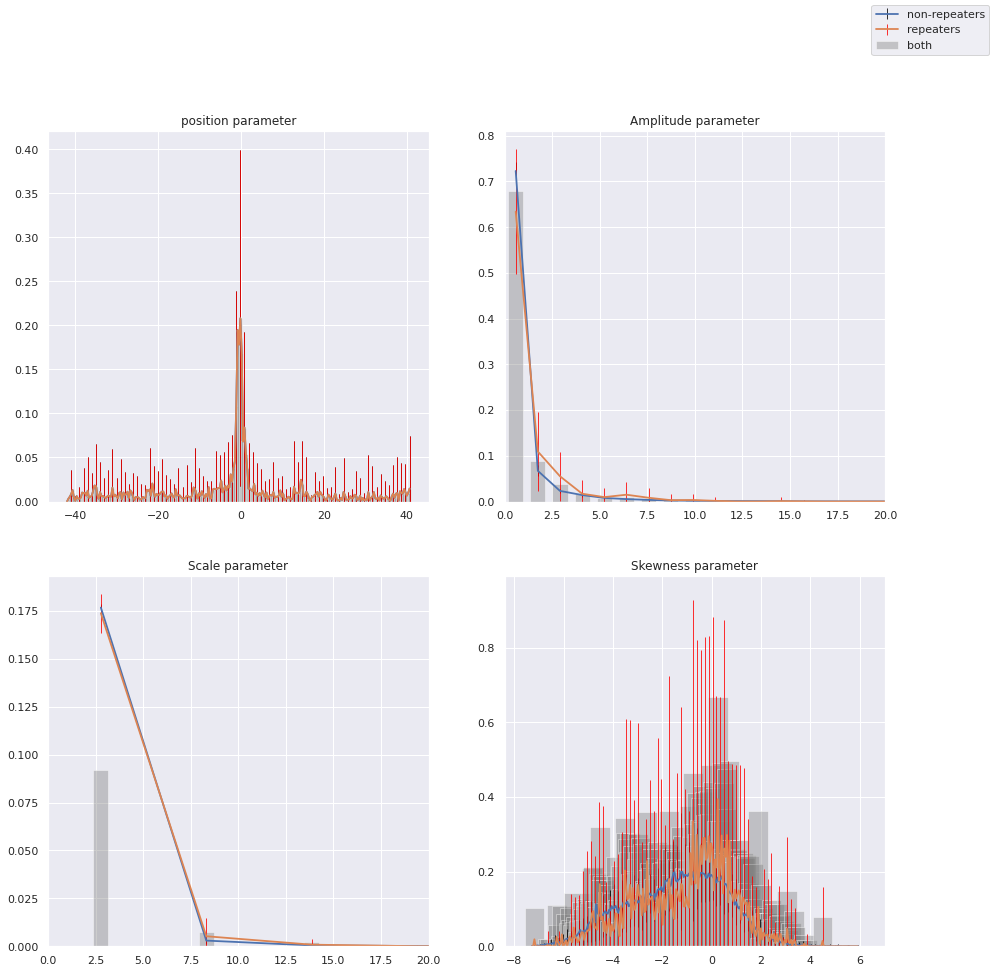

In [99]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = np.hstack(axes)
axes[0].errorbar(x=np_mids_npos, y=np_mean_bins_npos, yerr=np_std_bins_npos, linewidth=1.8, ecolor="black", elinewidth=0.8, label="non-repeaters", errorevery=3)
axes[0].errorbar(x=rp_mids_npos, y=rp_mean_bins_npos, yerr=rp_std_bins_npos, linewidth=1.8, ecolor="red", elinewidth=0.8, label="repeaters", errorevery=3)
axes[0].bar(x=rp_mids_npos, height=combine(rp_mean_bins_npos, np_mean_bins_npos), label="both", alpha=0.4, color="grey")
axes[0].set_title("position parameter")
axes[0].set_ylim(0)

axes[1].errorbar(x=np_mids_amp, y=np_mean_bins_amp, yerr=np_std_bins_amp, linewidth=1.8, ecolor="black", elinewidth=0.8)
axes[1].errorbar(x=rp_mids_amp, y=rp_mean_bins_amp, yerr=rp_std_bins_amp, linewidth=1.8, ecolor="red", elinewidth=0.8)
axes[1].bar(x=rp_mids_amp, height=combine(np_mean_bins_amp, rp_mean_bins_amp), alpha=0.4, color="grey")
axes[1].set_ylim(0)
axes[1].set_xlim(0, 20)
axes[1].set_title("Amplitude parameter")

axes[2].errorbar(x=np_mids_scale, y=np_mean_bins_scale, yerr=np_std_bins_scale, linewidth=1.8, ecolor="black", elinewidth=0.8)
axes[2].errorbar(x=rp_mids_scale, y=rp_mean_bins_scale, yerr=rp_std_bins_scale, linewidth=1.8, ecolor="red", elinewidth=0.8)
axes[2].bar(x=rp_mids_scale, height=combine(rp_mean_bins_scale, rp_std_bins_scale), alpha=0.4, color="grey")
axes[2].set_title("Scale parameter")
axes[2].set_xlim(0, 20)
axes[2].set_ylim(0)

axes[3].errorbar(x=np_mids_skew, y=np_mean_bins_skew, yerr=np_std_bins_skew, linewidth=1.8, ecolor="black", elinewidth=0.8, errorevery=3)
axes[3].errorbar(x=rp_mids_skew, y=rp_mean_bins_skew, yerr=rp_std_bins_skew, linewidth=1.8, ecolor="red", elinewidth=0.8, errorevery=3)
axes[3].bar(x=rp_mids_skew, height=combine(rp_mean_bins_skew, rp_std_bins_skew), alpha=0.4, color="grey")
axes[3].set_ylim(0)
axes[3].set_title("Skewness parameter")

fig.legend()

#### Number of peaks for repeaters versus non-repeaters

(0.0, 0.625531914893617)

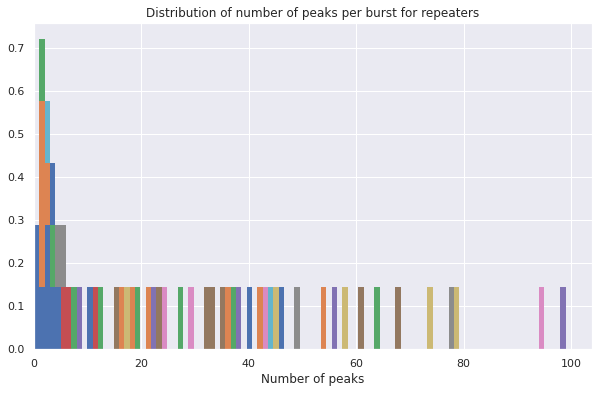

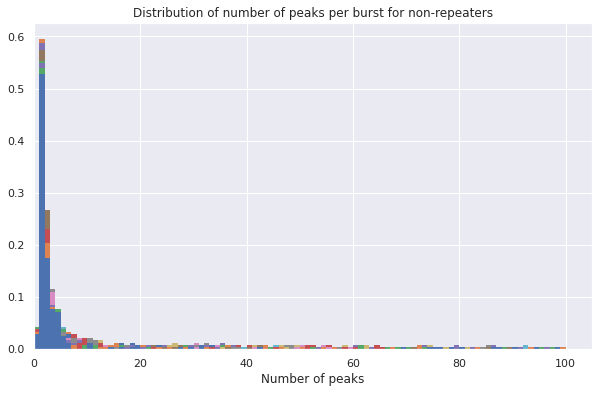

In [104]:
plt.figure(figsize=(10,6))
rp_n_nbursts, rp_bins_nbursts, __ = plt.hist(rp_final_nbursts, bins=100, histtype="stepfilled", density=True, edgecolor='none')
plt.title("Distribution of number of peaks per burst for repeaters")
plt.xlabel("Number of peaks")
plt.xlim(0)
plt.ylim(0)

plt.figure(figsize=(10,6))
np_n_nbursts, np_bins_nbursts, __ = plt.hist(np_final_nbursts, bins=100, histtype="stepfilled", density=True, edgecolor='none')
plt.title("Distribution of number of peaks per burst for non-repeaters")
plt.xlabel("Number of peaks")
plt.xlim(0)
plt.ylim(0)

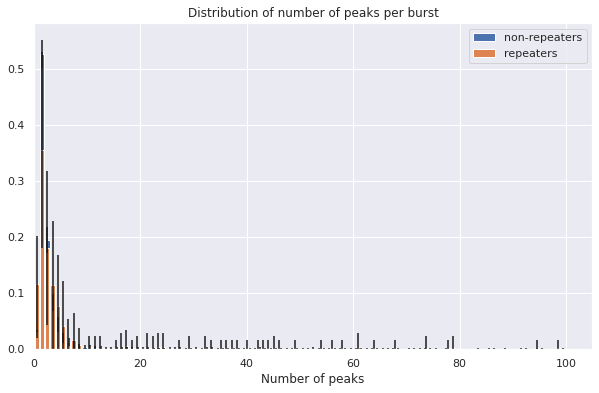

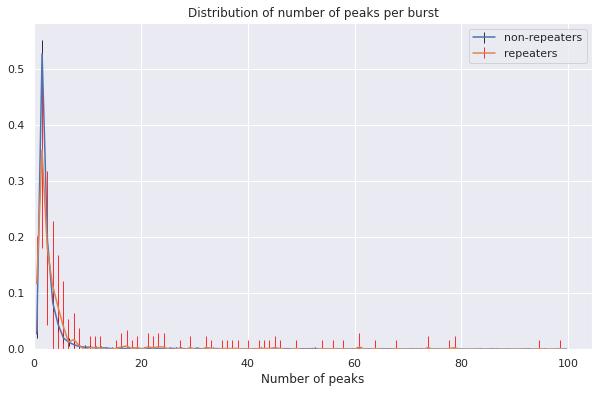

In [105]:
nbins_nbursts = 100
rp_mids_nbursts, rp_mean_nbursts, rp_std_nbursts = bin_values(rp_n_nbursts, rp_bins_nbursts)
np_mids_nbursts, np_mean_nbursts, np_std_nbursts = bin_values(np_n_nbursts, np_bins_nbursts)

plt.figure(figsize=(10,6))
plt.bar(x=np_mids_nbursts, height=np_mean_nbursts, yerr=np_std_nbursts, label="non-repeaters")
plt.bar(x=rp_mids_nbursts, height=rp_mean_nbursts, yerr=rp_std_nbursts, label="repeaters")
plt.title("Distribution of number of peaks per burst")
plt.xlabel("Number of peaks")
plt.xlim(0)
plt.ylim(0)
plt.legend()

plt.figure(figsize=(10,6))
plt.errorbar(x=np_mids_nbursts, y=np_mean_nbursts, yerr=np_std_nbursts, ecolor="black", elinewidth=0.8, label="non-repeaters")
plt.errorbar(x=rp_mids_nbursts, y=rp_mean_nbursts, yerr=rp_std_nbursts, ecolor="red", elinewidth=0.8, label="repeaters")
plt.title("Distribution of number of peaks per burst")
plt.xlabel("Number of peaks")
plt.xlim(0)
plt.ylim(0)
plt.legend()

#### Wait time distribution for repeaters versus non-repeaters

Text(0.5, 0, 'Time (ms)')

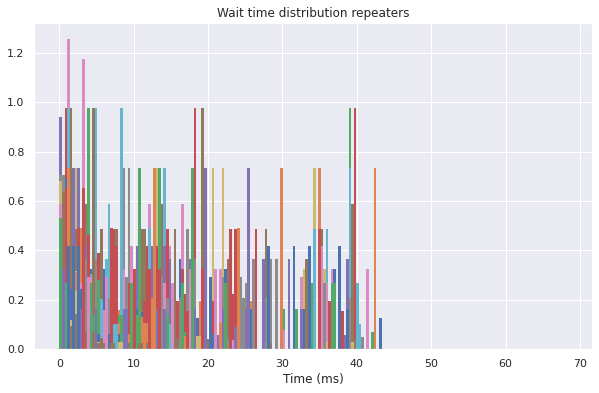

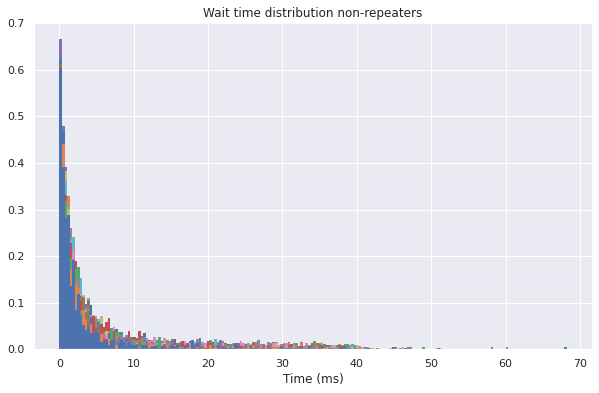

In [107]:
nbins_wait_time = 200
plt.figure(figsize=(10,6))
rp_n_wait_time, rp_bins_wait_time, __ = plt.hist(rp_final_wait_time, bins=nbins_wait_time, range=[min_wait_time, max_wait_time], histtype="stepfilled", density=True, edgecolor='none')
plt.title("Wait time distribution repeaters")
plt.xlabel("Time (ms)")
# plt.xlim(0,20)

plt.figure(figsize=(10,6))
np_n_wait_time, np_bins_wait_time, __ = plt.hist(np_final_wait_time, bins=nbins_wait_time, range=[min_wait_time, max_wait_time], histtype="stepfilled", density=True, edgecolor='none')
plt.title("Wait time distribution non-repeaters")
plt.xlabel("Time (ms)")
# plt.xlim(0,20)

(0.0, 0.583333684405158)

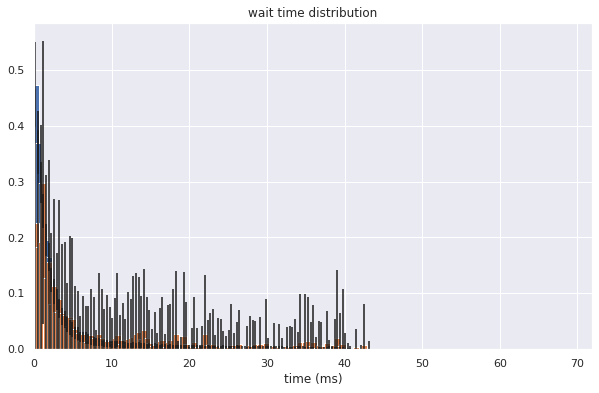

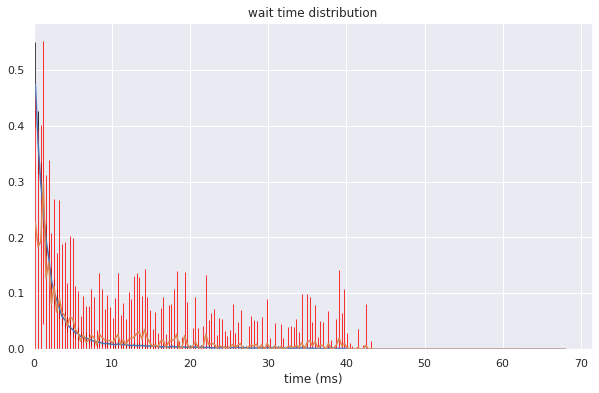

In [109]:
rp_mids_wait_time, rp_mean_bins_wait_time, rp_std_bins_wait_time = bin_values(rp_n_wait_time, rp_bins_wait_time)
np_mids_wait_time, np_mean_bins_wait_time, np_std_bins_wait_time = bin_values(np_n_wait_time, np_bins_wait_time)

plt.figure(figsize=(10,6))
plt.bar(x=np_mids_wait_time, height=np_mean_bins_wait_time, yerr=np_std_bins_wait_time, label="non-repeaters")
plt.bar(x=rp_mids_wait_time, height=rp_mean_bins_wait_time, yerr=rp_std_bins_wait_time, label="repeaters")
plt.title("wait time distribution")
plt.xlabel("time (ms)")
plt.xlim(0)
plt.ylim(0)
# plt.xlim(0,15)

plt.figure(figsize=(10,6))
plt.errorbar(x=np_mids_wait_time, y=np_mean_bins_wait_time, yerr=np_std_bins_wait_time, ecolor="black", elinewidth=0.8, label="non-repeaters")
plt.errorbar(x=rp_mids_wait_time, y=rp_mean_bins_wait_time, yerr=rp_std_bins_wait_time, ecolor="red", elinewidth=0.8, label="repeaters")
plt.title("wait time distribution")
plt.xlabel("time (ms)")
plt.xlim(0)
plt.ylim(0)
# plt.xlim(0,15)

(0.0, 50.0)

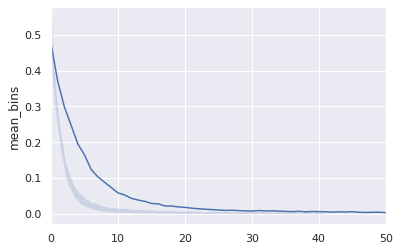

In [110]:
df_hist = pd.DataFrame(
    {'mids'  : np_mids_wait_time,
     'mean_bins'  : np_mean_bins_wait_time,
     'err'   : np_std_bins_wait_time,
     'lower' : substract(np_mean_bins_wait_time,np_std_bins_wait_time),
     'upper' : add(np_mean_bins_wait_time, np_std_bins_wait_time)
    })


ax = sns.lineplot(data=df_hist, x=df_hist.index, y="mean_bins", errorbar="ci")
ax.fill_between(df_hist.mids, df_hist.lower, df_hist.upper, alpha=0.2)
ax.set_xlim(0,50)


# # sns.lineplot(df_hist, x="mids", y="mean") #, errorbar="sd") #, errorbar=rp_std_bins_wait_time)
# sns.relplot(np_final_wait_time, kind="line", legend=False)
# # sns.lineplot(rp_mean_bins_wait_time)

# Plot average per draw

Calculate the average skewness per draw and plot these. 

Average skewness for repeaters -1.1089847658133782 +/- 0.9879050416568571
Average skewness for non-repeaters -1.4334543718718549 +/- 0.27511903372950125


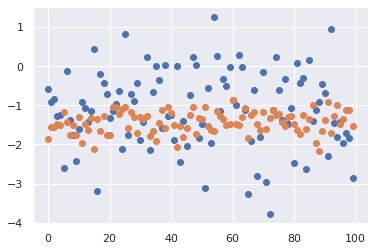

In [111]:
rp_avg_skew = [np.mean(i) for i in rp_final_skew]
np_avg_skew = [np.mean(i) for i in np_final_skew]

plt.plot(rp_avg_skew, marker='o', linestyle="None")
plt.plot(np_avg_skew, marker='o', linestyle='None')

print(f"Average skewness for repeaters {np.mean(rp_avg_skew)} +/- {np.std(rp_avg_skew)}")
print(f"Average skewness for non-repeaters {np.mean(np_avg_skew)} +/- {np.std(np_avg_skew)}")

Average amplitude for repeaters 1.0996021049665512 +/- 0.6208533926577577
Average amplitude for non-repeaters 1.0715463250682766 +/- 0.14314428663152237


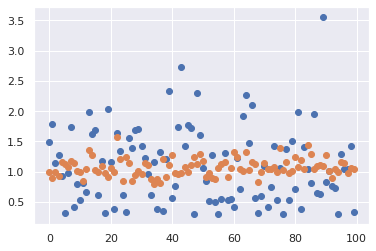

In [112]:
rp_avg_amp = [np.mean(i) for i in rp_final_amp]
np_avg_amp = [np.mean(i) for i in np_final_amp]

plt.plot(rp_avg_amp, marker='o', linestyle="None")
plt.plot(np_avg_amp, marker='o', linestyle='None')

print(f"Average amplitude for repeaters {np.mean(rp_avg_amp)} +/- {np.std(rp_avg_amp)}")
print(f"Average amplitude for non-repeaters {np.mean(np_avg_amp)} +/- {np.std(np_avg_amp)}")

# Sample test

The null hypothesis is that the skewness of repeaters and non-repeaters is drawn from the same distribution. We choose a confidence level of 95%. So, we will reject the null hypothesis in favor of the alternative if the p-value is less than 0.05. 

In [113]:
def sample_test(rp_final, np_final):
    """Return a list of all the KS-Test statistic and p-values 
    for each of the 100 draws. Also print the average mean and std
    for repeaters and non-repeaters. 
    """

    rp_avg = [np.mean(i) for i in rp_final]
    np_avg = [np.mean(i) for i in np_final]

    print(f"Average for repeaters {np.mean(rp_avg)} +/- {np.std(rp_avg)}")
    print(f"Average for non-repeaters {np.mean(np_avg)} +/- {np.std(np_avg)}")
    
    all_stat = []
    all_pval = []
    for idx in range(100):
        statistic, p_value = stats.ks_2samp(rp_final[idx], np_final[idx])
        all_stat.append(statistic)
        all_pval.append(p_value)

    return all_stat, all_pval

In [114]:
print("Amplitude:")
all_stat_amp, all_pval_amp = sample_test(rp_final_amp, np_final_amp)

print("\nPosition:")
all_stat_npos, all_pval_npos =sample_test(rp_final_npos, np_final_npos)

print("\nScale:")
all_stat_scale, all_pval_scale =sample_test(rp_final_scale, np_final_scale)

print("\nSkewness:")
all_stat_skew, all_pval_skew =sample_test(rp_final_skew, np_final_skew)

print("\nFluence:")
all_stat_fluence, all_pval_fluence =sample_test(rp_final_fluence, np_final_fluence)

Amplitude:
Average for repeaters 1.0996021049665512 +/- 0.6208533926577577
Average for non-repeaters 1.0715463250682766 +/- 0.14314428663152237

Position:
Average for repeaters -1.7288181698682794 +/- 2.658270718784254
Average for non-repeaters -1.0623877561718167 +/- 0.577772171914335

Scale:
Average for repeaters 1.791165271729027 +/- 1.1277773565919436
Average for non-repeaters 1.375782840019334 +/- 0.28117156593713355

Skewness:
Average for repeaters -1.1089847658133782 +/- 0.9879050416568571
Average for non-repeaters -1.4334543718718549 +/- 0.27511903372950125

Fluence:
Average for repeaters 0.1270646977996857 +/- 2.0749606697866434
Average for non-repeaters -0.025885944132361418 +/- 0.3951843675214877


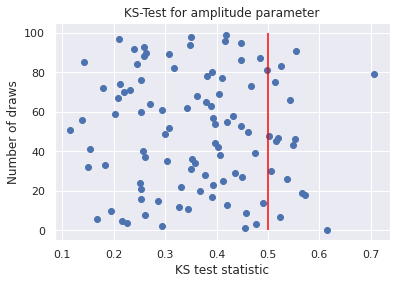

In [115]:
plt.scatter(all_stat_amp, y=np.arange(0,100, 1))
plt.title("KS-Test for amplitude parameter")
plt.xlabel("KS test statistic")
plt.ylabel("Number of draws")
plt.vlines(0.5, ymin=0, ymax=100, colors="red")

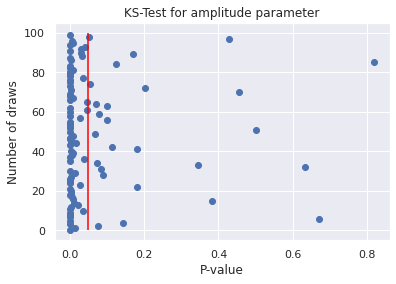

In [116]:
plt.scatter(all_pval_amp, y=np.arange(0,100, 1))
plt.title("KS-Test for amplitude parameter")
plt.xlabel("P-value")
plt.ylabel("Number of draws")
plt.vlines(0.05, ymin=0, ymax=100, colors="red")

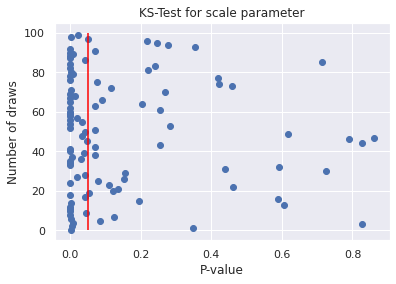

In [117]:
plt.scatter(all_pval_scale, y=np.arange(0,100, 1))
plt.title("KS-Test for scale parameter")
plt.xlabel("P-value")
plt.ylabel("Number of draws")
plt.vlines(0.05, ymin=0, ymax=100, colors="red")

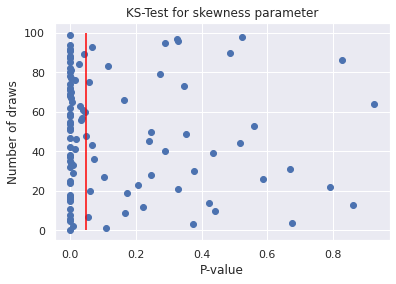

In [118]:
plt.scatter(all_pval_skew, y=np.arange(0,100, 1))
plt.title("KS-Test for skewness parameter")
plt.xlabel("P-value")
plt.ylabel("Number of draws")
plt.vlines(0.05, ymin=0, ymax=100, colors="red")

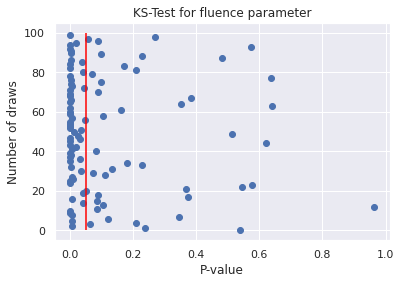

In [119]:
plt.scatter(all_pval_fluence, y=np.arange(0,100, 1))
plt.title("KS-Test for fluence parameter")
plt.xlabel("P-value")
plt.ylabel("Number of draws")
plt.vlines(0.05, ymin=0, ymax=100, colors="red")

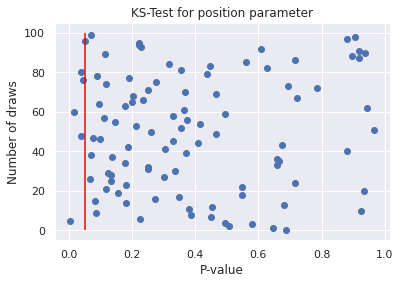

In [120]:
plt.scatter(all_pval_npos, y=np.arange(0,100, 1))
plt.title("KS-Test for position parameter")
plt.xlabel("P-value")
plt.ylabel("Number of draws")
plt.vlines(0.05, ymin=0, ymax=100, colors="red")

The p-value is lower than our threshold of 0.05, so we reject the null hypothesis in favor of the default “two-sided” alternative: the data were not drawn from the same distribution.

## Plot the fluence 
Make a plot of the fluence distribution

Text(0.5, 1.0, 'fluence distribution')

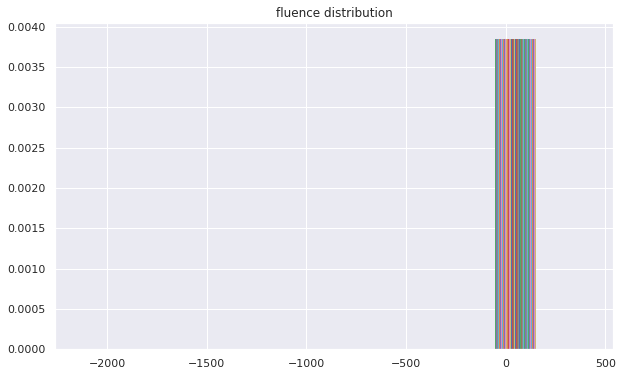

In [123]:
plt.figure(figsize=(10,6))
n_fluence, bins_fluence, __ = plt.hist(final_fluence, density=True, edgecolor='none')
plt.title("fluence distribution")

Text(0.5, 1.0, 'fluence distribution')

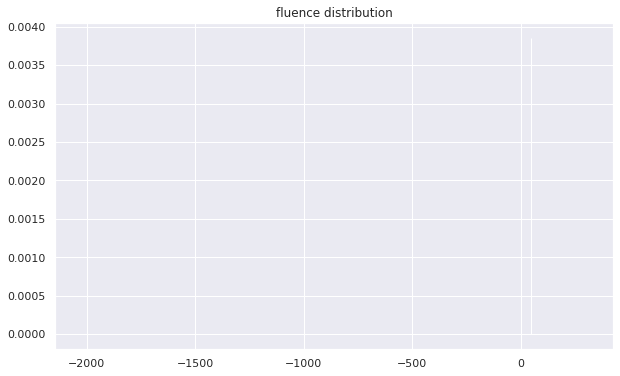

In [124]:
mids_fluence, mean_bins_fluence, std_bins_fluence = bin_values(n_fluence, bins_fluence)

plt.figure(figsize=(10,6))
plt.bar(x=mids_fluence, height=mean_bins_fluence, yerr=std_bins_fluence)
plt.title("fluence distribution")

In [125]:
df = pd.DataFrame(
    {'fluence'  : final_fluence[0],
     'skewness' : final_skew[0],
     'scale'    : final_scale[0],
     'amplitude': final_amp[0]
    })

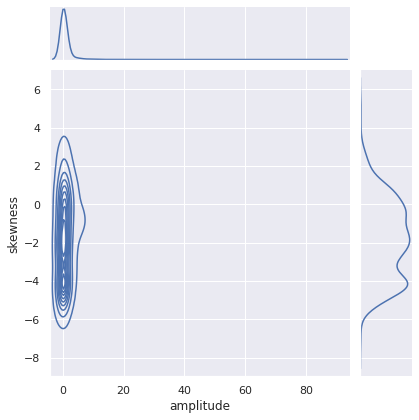

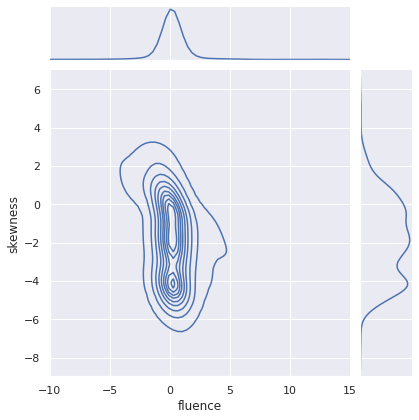

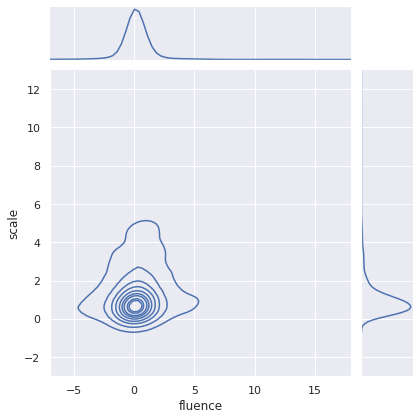

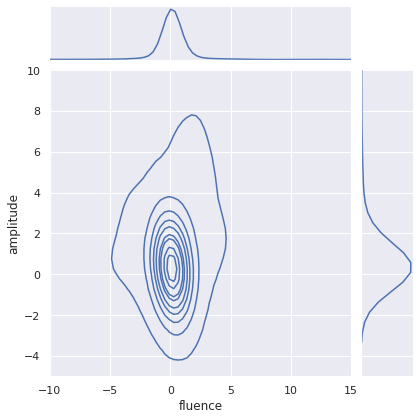

In [126]:
sns.jointplot(data=df, x='amplitude', y='skewness', dropna=True, kind="kde")
sns.jointplot(data=df, x='fluence', y='skewness', dropna=True, kind="kde", xlim=(-10,15))
sns.jointplot(data=df, x='fluence', y='scale', dropna=True, kind="kde", xlim=(-7,18), ylim=(-3,13))
sns.jointplot(data=df, x='fluence', y='amplitude', dropna=True, kind="kde", xlim=(-10,15), ylim=(-5,10))

In [128]:
# get all parameters into one list
all_fluence = []
for i in final_fluence:
    all_fluence.extend(i)

all_skew = []
for i in final_skew:
    all_skew.extend(i)

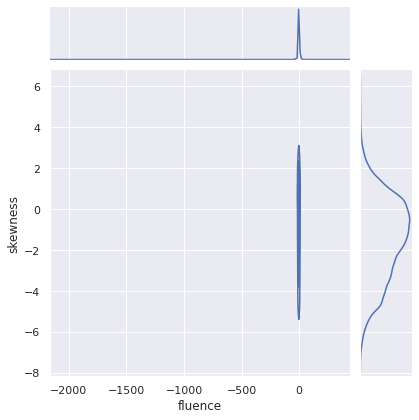

In [130]:
# Note: statistically not correct!!
df = pd.DataFrame(
    {'fluence'  : all_fluence,
     'skewness' : all_skew
    })

sns.jointplot(data=df, x='fluence', y='skewness', dropna=True, kind="kde")
